## Base de dados - import

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

In [3]:
url = ("https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.xls")
df = pd.read_excel(url)
orig_df = df

## Dataframe

In [4]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df




## Separação treino e teste

In [5]:
def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

## Exploração inicial dos dados

In [6]:
X.shape

(1309, 8)

In [7]:
X.describe().iloc[:, [0, -1]]

,pclass,embarked_S
count,1309.000000,1309.000000
mean,-0.012831,0.698243
std,0.995822,0.459196
min,-1.551881,0.000000
25%,-0.363317,0.000000
50%,0.825248,1.000000
75%,0.825248,1.000000
max,0.825248,1.000000


In [8]:
X.iloc[[1, 4], -3:]

,sex_male,embarked_Q,embarked_S
677,1,0,1
864,0,0,1


In [9]:
X.loc[[677, 864], "sex_male":]

,sex_male,embarked_Q,embarked_S
677,1,0,1
864,0,0,1


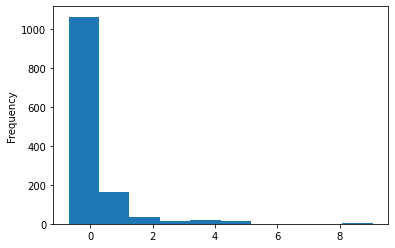

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
X.fare.plot(kind="hist", ax=ax)
fig.savefig("./images/mlpr_0601.png", dpi=300)

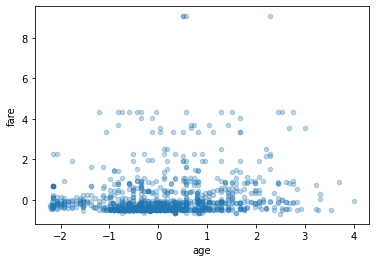

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
X.plot.scatter(
    x="age", y="fare", ax=ax, alpha=0.3
)
fig.savefig("./images/mlpr_0603.png", dpi=300)

In [12]:
X.age.corr(X.fare)

0.17719974839989594

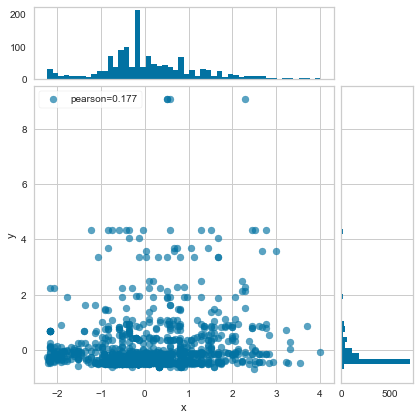

In [13]:
from yellowbrick.features import (
    JointPlotVisualizer,
)
fig, ax = plt.subplots(figsize=(6, 6))
jpv = JointPlotVisualizer(
    feature="age", target="fare"
)
jpv.fit(X["age"], X["fare"])
jpv.poof()
fig.savefig("./images/mlpr_0604.png", dpi=300)

C:\ProgramData\Anaconda3\envs\Machine-Learning-guia-referencia\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


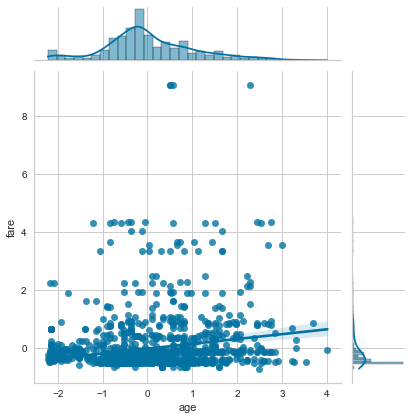

In [14]:
from seaborn import jointplot
new_df = X.copy()
new_df["target"] = y
p = jointplot(
    "age", "fare", data=new_df, kind="reg"
)
p.fig.savefig("images/mlpr_0605.png", dpi=300)

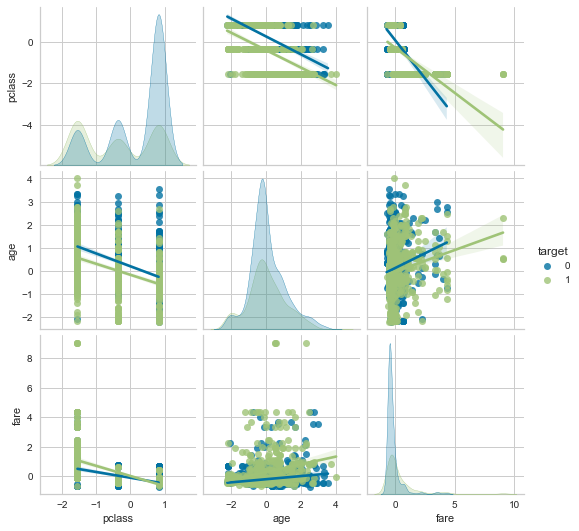

In [15]:
from seaborn import pairplot
new_df = X.copy()
new_df["target"] = y
vars = ["pclass", "age", "fare"]
p = pairplot(
    new_df, vars=vars, hue="target", kind="reg"
)
p.fig.savefig("images/mlpr_0606.png", dpi=300)

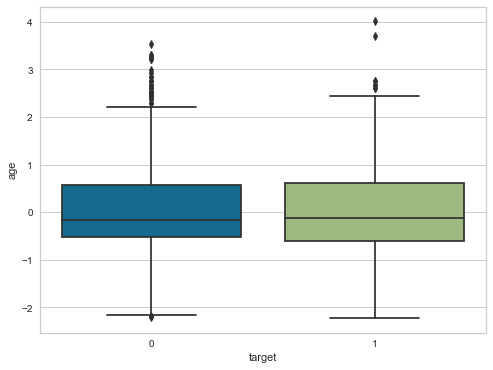

In [16]:
from seaborn import boxplot
fig, ax = plt.subplots(figsize=(8, 6))
new_df = X.copy()
new_df["target"] = y
boxplot(x="target", y="age", data=new_df)
fig.savefig("images/mlpr_0607.png", dpi=300)

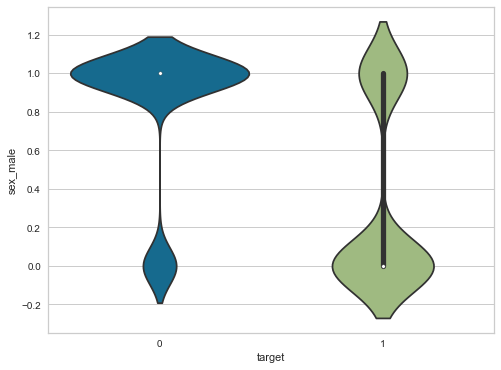

In [17]:
from seaborn import violinplot
fig, ax = plt.subplots(figsize=(8, 6))
new_df = X.copy()
new_df["target"] = y
violinplot(
    x="target", y="sex_male", data=new_df
)
fig.savefig("images/mlpr_0608.png", dpi=300)

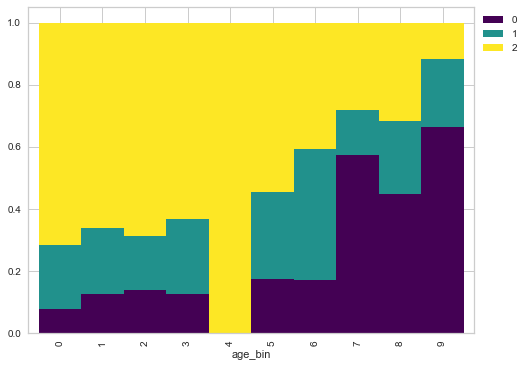

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
(
    X.assign(
        age_bin=pd.qcut(
            X.age, q=10, labels=False
        ),
        class_bin=pd.cut(
            X.pclass, bins=3, labels=False
        ),
    )
    .groupby(["age_bin", "class_bin"])
    .size()
    .unstack()
    .pipe(lambda df: df.div(df.sum(1), axis=0))
    .plot.bar(
        stacked=True,
        width=1,
        ax=ax,
        cmap="viridis",
    )
    .legend(bbox_to_anchor=(1, 1))
)
fig.savefig(
    "images/mlpr_0609.png",
    dpi=300,
    bbox_inches="tight",
)

## Correlação

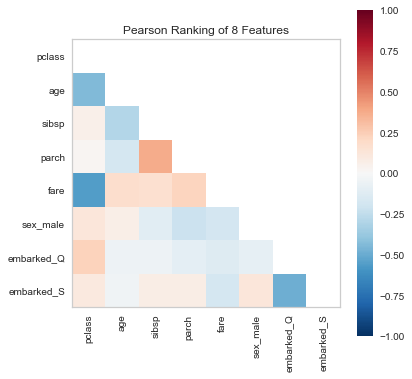

In [19]:
from yellowbrick.features import Rank2D
fig, ax = plt.subplots(figsize=(6, 6))
pcv = Rank2D(
    features=X.columns, algorithm="pearson"
)
pcv.fit(X, y)
pcv.transform(X)
pcv.poof()
fig.savefig(
    "images/mlpr_0610.png",
    dpi=300,
    bbox_inches="tight",
)

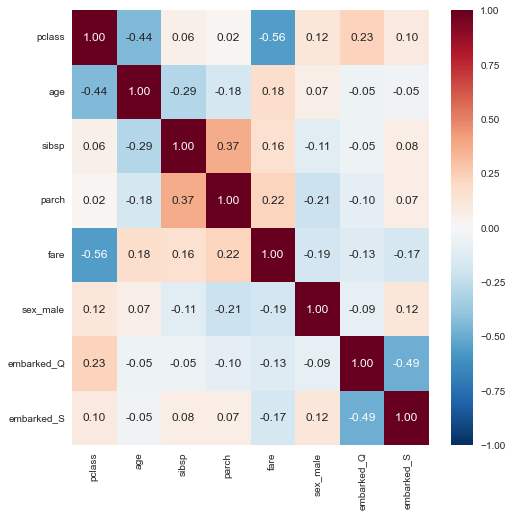

In [20]:
from seaborn import heatmap
fig, ax = plt.subplots(figsize=(8, 8))
ax = heatmap(
    X.corr(),
    fmt=".2f",
    annot=True,
    ax=ax,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)
fig.savefig(
    "images/mlpr_0611.png",
    dpi=300,
    bbox_inches="tight",
)

In [21]:
X.corr().iloc[:, :2]

,pclass,age
pclass,1.000000,-0.439704
age,-0.439704,1.000000
sibsp,0.060832,-0.292056
parch,0.018322,-0.176447
fare,-0.558827,0.177200
sex_male,0.124617,0.065004
embarked_Q,0.230491,-0.053904
embarked_S,0.096335,-0.045361


## Identificando colunas correlacionadas

In [22]:
def correlated_columns(df, threshold=0.95):
    return (
        df.corr()
        .pipe(
            lambda df1: pd.DataFrame(
                np.tril(df1, k=-1),
                columns=df.columns,
                index=df.columns,
            )
        )
        .stack()
        .rename("pearson")
        .pipe(
            lambda s: s[
                s.abs() > threshold
            ].reset_index()
        )
        .query("level_0 not in level_1")
    )
correlated_columns(X)

,level_0,level_1,pearson


In [23]:
agg = (df.groupby("cabin").agg("min,max,mean,sum".split(",")).reset_index())
agg.columns = [ "_".join(c).strip("_")for c in agg.columns.values]
agg_df = df.merge(agg, on="cabin")

C:\Users\barba\AppData\Local\Temp\ipykernel_3120\872348446.py:1: FutureWarning: ['name', 'sex', 'ticket', 'embarked', 'boat', 'home.dest'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  agg = (df.groupby("cabin").agg("min,max,mean,sum".split(",")).reset_index())


In [24]:
c_df = correlated_columns(agg_df.select_dtypes('number'))
c_df.style.format({"pearson": "{:.2f}"})

,level_0,level_1,pearson
3,pclass_mean,pclass,1.00
4,pclass_mean,pclass_min,1.00
5,pclass_mean,pclass_max,1.00
6,sibsp_mean,sibsp_max,0.97
7,parch_mean,parch_min,0.95
8,parch_mean,parch_max,0.96
9,fare_mean,fare,0.95
10,fare_mean,fare_max,0.98
17,body_sum,body,1.00
18,body_sum,body_min,1.00


## Gráfico RadViz com dados normalizados

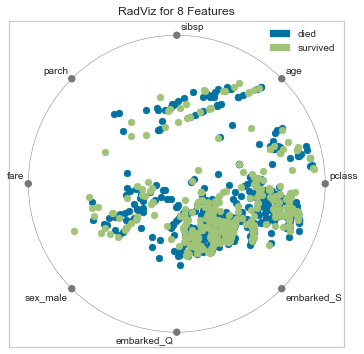

In [31]:
from yellowbrick.features import RadViz
fig, ax = plt.subplots(figsize=(6, 6))
rv = RadViz(
    classes=["died", "survived"],
    features=X.columns,
)
rv.fit(X, y)
_ = rv.transform(X)
rv.poof()
fig.savefig("images/mlpr_0612.png", dpi=300)

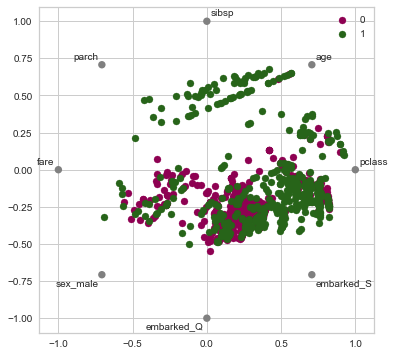

In [32]:
from pandas.plotting import radviz
fig, ax = plt.subplots(figsize=(6, 6))
new_df = X.copy()
new_df["target"] = y
radviz(
    new_df, "target", ax=ax, colormap="PiYG"
)
fig.savefig("images/mlpr_0613.png", dpi=300)

## Coordenadas paralelas, analise de base com dados multivalorados

C:\Users\barba\AppData\Local\Temp\ipykernel_3120\4286116709.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


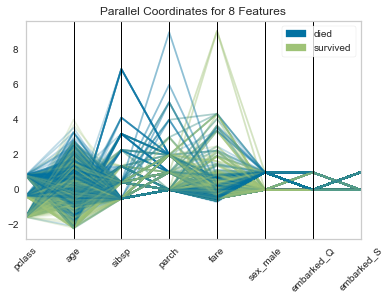

In [34]:
from yellowbrick.features import (
    ParallelCoordinates,
)
fig, ax = plt.subplots(figsize=(6, 4))
pc = ParallelCoordinates(
    classes=["died", "survived"],
    features=X.columns,
)
pc.fit(X, y)
pc.transform(X)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45
)
pc.poof()
fig.savefig("images/mlpr_0614.png", dpi=300)

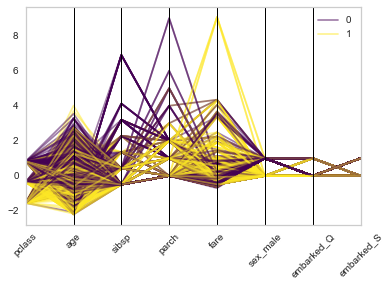

In [35]:
from pandas.plotting import (
    parallel_coordinates,
)
fig, ax = plt.subplots(figsize=(6, 4))
new_df = X.copy()
new_df["target"] = y
parallel_coordinates(
    new_df,
    "target",
    ax=ax,
    colormap="viridis",
    alpha=0.5,
)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation=45
)
fig.savefig(
    "images/mlpr_0615.png",
    dpi=300,
    bbox_inches="tight",
)